In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

#### Creación del modelo:

In [2]:
# Definir la arquitectura EfficientNetB0 adaptada a segmentación
def build_efficientnet_segmentation(input_shape=(224, 224, 3), num_classes=1):
    # Cargar el modelo EfficientNetB0 sin la capa superior (sin clasificación)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Extraer las salidas de algunos bloques intermedios para las conexiones de "skip"
    skip_connection_names = ['block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation']
    skip_connections = [base_model.get_layer(name).output for name in skip_connection_names]

    # La salida de EfficientNet
    output = base_model.output

    # Upsampling y concatenación de skip connections para segmentación
    for i in range(4):
        output = UpSampling2D((2, 2))(output)
        output = Concatenate()([output, skip_connections[3 - i]])

        output = Conv2D(256 // (2**i), (3, 3), padding='same', activation='relu')(output)

    # Paso final: Upsampling adicional para asegurar que el tamaño de salida sea 224x224
    output = UpSampling2D((2, 2))(output)


    # Capa de salida: máscara de segmentación (224x224x1). Conv2D para la predicción de la máscara
    output = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(output)

    # Construir el modelo completo
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Crear el modelo
model = build_efficientnet_segmentation(input_shape=(224, 224, 3), num_classes=1)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Carga de datos:

In [3]:
!git clone https://github.com/Sekkan-soluciones-biomedicas/FootSegmentation_4.git   # Clonamos el repositorio de archivos e imágenes.

Cloning into 'FootSegmentation_4'...
remote: Enumerating objects: 4383, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 4383 (delta 169), reused 328 (delta 139), pack-reused 4021 (from 1)
Receiving objects: 100% (4383/4383), 348.69 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (1362/1362), done.
Updating files: 100% (3985/3985), done.


In [4]:
import pandas as pd
import io
import numpy as np
from PIL import Image
import os

In [ ]:
df = pd.read_csv('/content/FootSegmentation_4/train_images2.csv')    # df de los paths de las imágenes y los labels(masks)

X_train_all = [path_img for path_img in df['images']]
Y_train_all = [path_mask for path_mask in df['masks']]

# Conjuntos reducidos:
ind_redc = 50
X_train = X_train_all[:ind_redc]
Y_train = Y_train_all[:ind_redc]

In [ ]:
len(Y_train_all)

831

In [ ]:
X_val = X_train_all[52:75]
Y_val = Y_train_all[52:75]

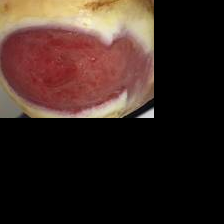

In [ ]:
Image.open(X_train[45])

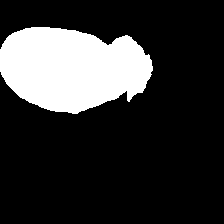

In [ ]:
Image.open(Y_train[45])

#### Otro conjunto de imágenes (tamaño):

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_paths = pd.read_csv('/content/FootSegmentation_4/dataset_images_paths.csv')
X_all_2 = [path_img for path_img in df_paths['images']]
Y_all_2 = [path_mask for path_mask in df_paths['masks']]

#### Probar el entrenamiento del modelo con:
# X_train_2 = X_all_2[:50]
# Y_train_2 = Y_all_2[:50]
# X_val_2 = X_all_2[52:75]
# Y_val_2 = Y_all_2[52:75]

x_train, x_val, y_train, y_val = train_test_split(X_all_2, Y_all_2, test_size=0.2, random_state=42)

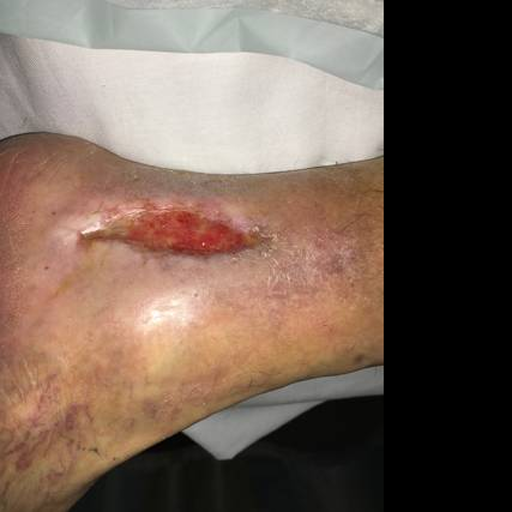

In [24]:
Image.open(x_train[55])

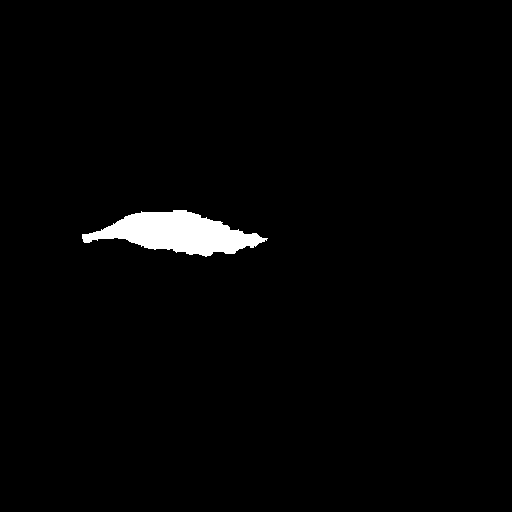

In [25]:
Image.open(y_train[55])

### Entrenamiento del modelo:

In [ ]:
import tensorflow as tf

# Función para preprocesar las imágenes y las máscaras de entrenamiento
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224, 224])

    image = image / 255.0  # Normalización de la imagen
    mask = mask / 255.0  # Normalización de la máscara (debe estar en rango [0,1])

    return image, mask

# Crear datasets a partir de listas de archivos
train_image_paths = X_train  # Lista con las rutas de las imágenes de entrenamiento
train_mask_paths = Y_train   # Lista con las rutas de las máscaras de entrenamiento

val_image_paths = X_val    # Lista con las rutas de las imágenes de validación
val_mask_paths = Y_val     # Lista con las rutas de las máscaras de validación

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(process_path).batch(32)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
validation_dataset = validation_dataset.map(process_path).batch(32)

In [ ]:
# Verificar si se está usando GPU
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Entrenar el modelo con los datasets
model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 178s 72s/step - accuracy: 0.3379 - loss: 1.1381 - val_accuracy: 0.9790 - val_loss: 0.2651
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.9669 - loss: 0.4579 - val_accuracy: 0.9790 - val_loss: 0.2167
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9666 - loss: 0.3299 - val_accuracy: 0.9790 - val_loss: 0.1664
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.9654 - loss: 0.2059 - val_accuracy: 0.9788 - val_loss: 0.1255
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9619 - loss: 0.1353 - val_accuracy: 0.9790 - val_loss: 0.1886
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9595 - loss: 0.0945 - val_accuracy: 0.9790 - val_loss: 0.3286
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9690 - loss: 0.0769 - val_accuracy: 0.9790 - val_loss: 0.4535
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.9746 - loss: 0.0641 - val_accuracy: 0.9790 - val_loss:

### Guardar el modelo como un archivo .tflite

In [ ]:
# Guardar el modelo en formato TensorFlow Lite (.tflite)
def convert_to_tflite(model, output_file='efficientnet_segmentation.tflite'):
    # Convertir el modelo a TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Guardar el modelo TFLite
    with open(output_file, 'wb') as f:
        f.write(tflite_model)


# Convertir y guardar el modelo
convert_to_tflite(model, output_file='efficientnet_segmentation.tflite');

Saved artifact at '/tmp/tmp09qe_miv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None)
Captures:
  136329381067440: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136329381066912: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136329383187504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329381056528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329381057760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329381062864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329381067792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329381059872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329245902976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136329245902624: TensorSpec(shape=(), dtype=tf.resource,

### Predicción de la máscara y la imágen segmentada a partir del modelo .tflite

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

def predict_segmentation_tflite(model_path, image_path, input_size=(224, 224)):
    """
    Esta función toma el path de un modelo .tflite y el path de una imagen, y realiza la predicción de la máscara de segmentación.

    Parámetros:
        - model_path: Ruta al modelo .tflite entrenado.
        - image_path: Ruta a la imagen que se desea segmentar.
        - input_size: Tamaño de entrada esperado por el modelo (default: 224x224).

    Retorna:
        - Un diccionario con la máscara binarizada y la imagen segmentada.
    """

    # Cargar la imagen desde el path
    img = Image.open(image_path)

    # Redimensionar la imagen al tamaño esperado por el modelo
    img_resized = img.resize(input_size)

    # Convertir la imagen a un array de numpy y normalizar a rango [0, 1]
    img_array = np.array(img_resized) / 255.0

    # Verificar si la imagen es en escala de grises o RGB
    if img_array.shape[-1] != 3:  # Si es en escala de grises
        img_array = np.stack([img_array] * 3, axis=-1)  # Convertirla a 3 canales (RGB)

    # Expandir dimensiones para que sea compatible con el modelo (batch_size=1)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Cargar el modelo TFLite
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Obtener detalles de entrada y salida del modelo
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Asignar la imagen de entrada al tensor del modelo
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Ejecutar la inferencia
    interpreter.invoke()

    # Obtener la predicción
    pred_mask = interpreter.get_tensor(output_details[0]['index'])

    # Remover la dimensión del batch
    pred_mask = np.squeeze(pred_mask)

    # Convertir la predicción a valores binarios (0 y 1)
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

    # Cargar la imagen original sin redimensionar
    original_image = np.array(Image.open(image_path))

    # Asegurarse de que la imagen original tenga 3 canales (RGB)
    if original_image.shape[-1] != 3:
        original_image = np.stack([original_image] * 3, axis=-1)

    # Redimensionar la máscara binarizada al tamaño de la imagen original
    mask_resized = np.array(Image.fromarray(pred_mask_binary).resize(original_image.shape[:2], Image.NEAREST))

    # Segmentar la imagen (aplicar la máscara binarizada a la imagen original)
    segmented_image = original_image * np.expand_dims(mask_resized, axis=-1)

    # Retornar un diccionario con la máscara binarizada y la imagen segmentada
    return {
        'mask': pred_mask_binary,            # Máscara binarizada (224x224)
        'segmented_image': segmented_image   # Imagen segmentada (resaltando la úlcera)
    }


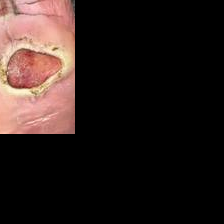

In [ ]:
Image.open(X_train_all[94])

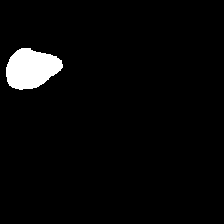

In [ ]:
Image.open(Y_train_all[94])

In [ ]:
X_train_all[92]

'FootSegmentation_4/images-unet/train/images/1576e366442683aac204404e081eb938_2.png'

In [ ]:
# Ruta del modelo .tflite y de la imagen
model_tflite_path = "/content/efficientnet_segmentation.tflite"
image_path = X_train_all[17]

# Obtener la predicción
result = predict_segmentation_tflite(model_tflite_path, image_path)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
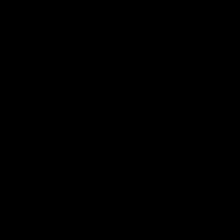

In [ ]:
result['mask']